<a href="https://colab.research.google.com/github/mkoutli/plant-disease-detection/blob/training/PlantVillage_Training_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PlantVillage Dataset Training

## Setup

In [ ]:
import os
import shutil
import random
from zipfile import ZipFile
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from io import BytesIO
import requests
import pdb
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt

import re
import numpy as np

# Set GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

#Confirm we can connect to GPU
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))


Found GPU at: /device:GPU:0


## Download and split the dataset

In [ ]:
# Download the PlantVillage dataset zip file
dataset_url = "https://data.mendeley.com/public-files/datasets/tywbtsjrjv/files/d5652a28-c1d8-4b76-97f3-72fb80f94efc/file_downloaded"
# Set up paths
dataset_path = '/content/PlantVillageDataset/Plant_leave_diseases_dataset_without_augmentation'
output_path = '/content/PlantVillageDataset/processed'
# Check if the 'dataset_path' folder exists
if not os.path.exists(dataset_path):
  response = requests.get(dataset_url)
  extracted_path = '/content/PlantVillageDataset'
  with ZipFile(BytesIO(response.content), 'r') as zip_ref:
      zip_ref.extractall(extracted_path)
# List contents of the extracted directory
extracted_contents = os.listdir(dataset_path)
print(extracted_contents)
# Remove background
background_path = os.path.join(dataset_path, 'Background_without_leaves')
if os.path.exists(background_path):
    shutil.rmtree(background_path)



# Function to resize and preprocess images
# def preprocess_images(image_path, output_path, target_size=(256, 256)):
#     img = load_img(image_path, target_size=target_size)
#     img_array = img_to_array(img)
#     img_array /= 255.0  # Normalize pixel values to be between 0 and 1
#     return img_array

# Function to split dataset into train, validation, and test sets
def split_dataset(dataset_path, output_path, test_size=0.2
                  #,  validation_size=0.1
                  ):

    # Check if the 'processed' folder exists, and delete it if it does
    if os.path.exists(output_path):
        print('processed folder will be removed and re-created')
        shutil.rmtree(output_path)

    classes = os.listdir(dataset_path)
    for cls in classes:
        cls_path = os.path.join(dataset_path, cls)
        images = os.listdir(cls_path)

        # Split data into training, validation, and test sets
        train_images, test_images = train_test_split(images, test_size=test_size, random_state=100)
        #train_images, val_images = train_test_split(train_images, test_size=validation_size, random_state=100)

        # Create directories for each set
        train_path = os.path.join(output_path, 'train', cls)
        #val_path = os.path.join(output_path, 'validation', cls)
        test_path = os.path.join(output_path, 'test', cls)

        os.makedirs(train_path, exist_ok=True)
        #os.makedirs(val_path, exist_ok=True)
        os.makedirs(test_path, exist_ok=True)

        # Copy images to corresponding directories
        for img in train_images:
            shutil.copy(os.path.join(cls_path, img), os.path.join(train_path, img))
        # for img in val_images:
        #     shutil.copy(os.path.join(cls_path, img), os.path.join(val_path, img))
        for img in test_images:
            shutil.copy(os.path.join(cls_path, img), os.path.join(test_path, img))

# Split the data to train, validation and test sets
split_dataset(dataset_path, output_path)


['Tomato___Target_Spot', 'Pepper,_bell___Bacterial_spot', 'Corn___healthy', 'Blueberry___healthy', 'Potato___healthy', 'Apple___healthy', 'Tomato___Septoria_leaf_spot', 'Grape___Esca_(Black_Measles)', 'Apple___Cedar_apple_rust', 'Grape___Black_rot', 'Strawberry___Leaf_scorch', 'Peach___healthy', 'Tomato___Late_blight', 'Apple___Apple_scab', 'Cherry___healthy', 'Tomato___Leaf_Mold', 'Tomato___Early_blight', 'Tomato___Bacterial_spot', 'Background_without_leaves', 'Corn___Northern_Leaf_Blight', 'Squash___Powdery_mildew', 'Raspberry___healthy', 'Potato___Late_blight', 'Corn___Common_rust', 'Pepper,_bell___healthy', 'Tomato___Tomato_mosaic_virus', 'Strawberry___healthy', 'Soybean___healthy', 'Tomato___healthy', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Potato___Early_blight', 'Cherry___Powdery_mildew', 'Orange___Haunglongbing_(Citrus_greening)', 'Apple___Black_rot', 'Grape___healthy', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Peach___Ba

## Explore dataset

In [ ]:
# List images
import pathlib
import PIL

data_dir = pathlib.Path(dataset_path).with_suffix('')
image_count = len(list(data_dir.glob('*/*.JPG')) + list(data_dir.glob('*/*.jpg')))
print('Total images:', image_count)

train_data_dir = pathlib.Path(output_path + '/train').with_suffix('')
image_train_count = len(list(train_data_dir.glob('*/*.JPG')) + list(train_data_dir.glob('*/*.jpg')))
print('Training set images:', image_train_count)

# val_data_dir = pathlib.Path(output_path + '/validation').with_suffix('')
# image_val_count = len(list(val_data_dir.glob('*/*.JPG')) + list(val_data_dir.glob('*/*.jpg')))
# print('Validation set images:', image_val_count)

test_data_dir = pathlib.Path(output_path + '/test').with_suffix('')
image_test_count = len(list(test_data_dir.glob('*/*.JPG')) + list(test_data_dir.glob('*/*.jpg')))
print('Test set images:', image_test_count)

Total images: 54303
Training set images: 43427
Test set images: 10876


Apple scab leaf

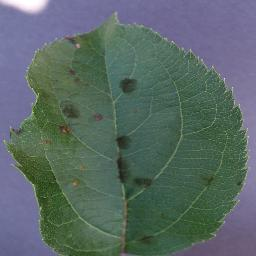

In [ ]:
apple_scab = list(data_dir.glob('Apple___Apple_scab/*'))
PIL.Image.open(str(apple_scab[0]))

Healthy cherry leaf

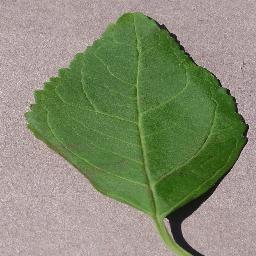

In [ ]:
cherry_healthy = list(data_dir.glob('Cherry___healthy/*'))
PIL.Image.open(str(cherry_healthy[0]))

## Load dataset with tensorflow

Found 43429 files belonging to 38 classes.
Using 34744 files for training.
Found 43429 files belonging to 38 classes.
Using 8685 files for validation.
['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry___Powdery_mildew', 'Cherry___healthy', 'Corn___Cercospora_leaf_spot Gray_leaf_spot', 'Corn___Common_rust', 'Corn___Northern_Leaf_Blight', 'Corn___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septo

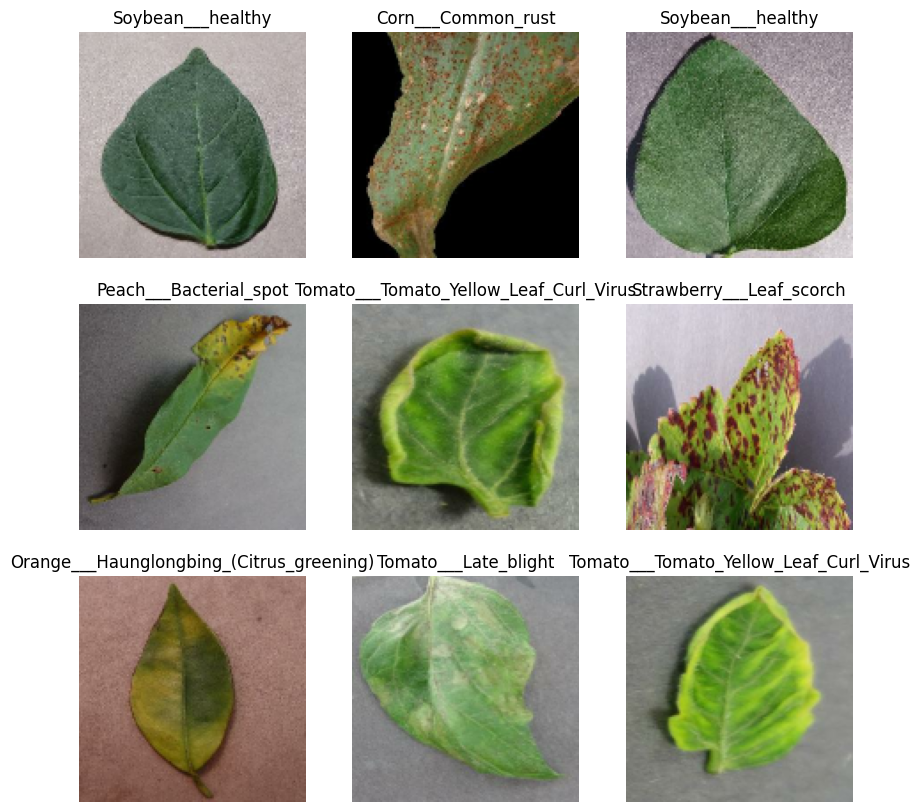

In [ ]:
# Data paths
train_data_path = output_path + '/train'

batch_size = 64
# Define image dimensions
# img_height = 256
# img_width = 256
img_height = 128
img_width = 128

train_ds = tf.keras.utils.image_dataset_from_directory(
  train_data_path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  train_data_path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names
print(class_names)

for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

num_classes = len(class_names)

## Define and compile the  Tensorflow model

In [ ]:
def create_model(num_classes):
  model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
  ])

  model.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])
  return model



model = create_model(num_classes)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 64, 64, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 32, 32, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 64)       

## Train

In [ ]:
epochs=10
with tf.device('/device:GPU:0'):
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
  )

Epoch 1/10
543/543 [==============================] - 52s 43ms/step - loss: 1.2297 - accuracy: 0.6539 - val_loss: 0.6284 - val_accuracy: 0.8016
Epoch 2/10
543/543 [==============================] - 11s 20ms/step - loss: 0.4775 - accuracy: 0.8515 - val_loss: 0.4131 - val_accuracy: 0.8672
Epoch 3/10
543/543 [==============================] - 11s 20ms/step - loss: 0.3006 - accuracy: 0.9035 - val_loss: 0.3512 - val_accuracy: 0.8864
Epoch 4/10
543/543 [==============================] - 11s 20ms/step - loss: 0.2084 - accuracy: 0.9316 - val_loss: 0.2907 - val_accuracy: 0.9083
Epoch 5/10
543/543 [==============================] - 11s 20ms/step - loss: 0.1430 - accuracy: 0.9529 - val_loss: 0.3336 - val_accuracy: 0.8975
Epoch 6/10
543/543 [==============================] - 11s 20ms/step - loss: 0.1050 - accuracy: 0.9649 - val_loss: 0.2667 - val_accuracy: 0.9206
Epoch 7/10
543/543 [==============================] - 11s 20ms/step - loss: 0.0850 - accuracy: 0.9724 - val_loss: 0.3061 - val_accuracy:

## Plot and save model

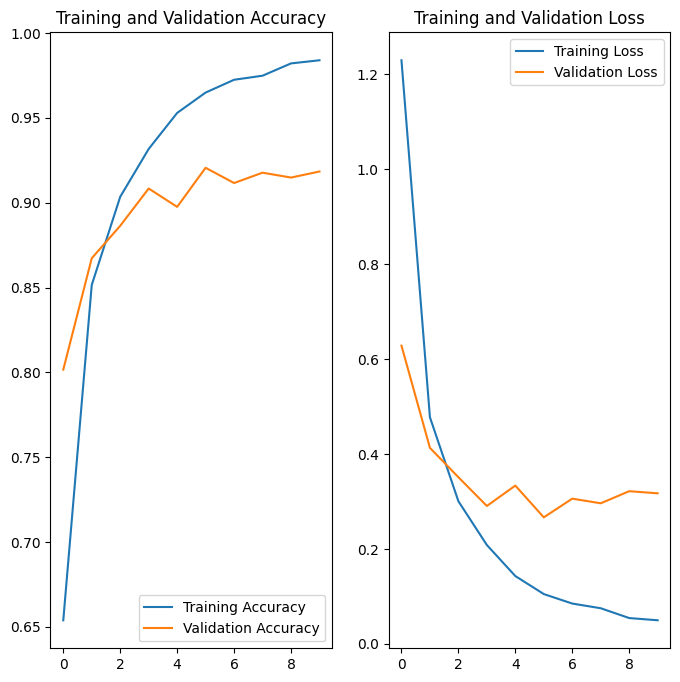

[INFO] Saving model...


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Dump file of the model
model_name = "model-i128-b64.keras"
print("[INFO] Saving model...")
model_path = '/content/PlantVillageDataset/models'
os.makedirs(model_path, exist_ok=True)
model.save(model_name)
# model.save(os.path.join(model_path, model_name))





## Test

In [ ]:
import pickle
import ntpath
import numpy as np
from numpy import asarray
from tensorflow.keras import layers, models

###### load test data #######
test_data_path = output_path + '/test'
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_data_path,
  seed=123,
  image_size=(img_height, img_width))

# Predict
def image_predict(path, model):
    img = tf.keras.utils.load_img(
    path, target_size=(img_height, img_width)
    )
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    head, tail = ntpath.split(path)
    print(
        "{} most likely belongs to {} with a {:.2f} percent confidence."
        .format(tail, class_names[np.argmax(score)], 100 * np.max(score))
    )

loaded_model = models.load_model(model_name)
data_test_dir_list = os.listdir(test_data_path)
for dataset in data_test_dir_list:
    img_list=os.listdir(test_data_path+'/'+ dataset)
    print ('Loaded the images of dataset-'+'{}\n'.format(dataset))
    for img in img_list:
        img_path = test_data_path + '/'+ dataset + '/'+ img
        image_predict(img_path, loaded_model)

test_loss, test_acc = model.evaluate(test_ds, verbose=2)

print(test_acc)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 31ms/step
image (812).JPG most likely belongs to Potato___Early_blight with a 100.00 percent confidence.
1/1 [==============================] - 0s 27ms/step
image (841).JPG most likely belongs to Potato___Early_blight with a 100.00 percent confidence.
1/1 [==============================] - 0s 27ms/step
image (407).JPG most likely belongs to Potato___Early_blight with a 99.97 percent confidence.
1/1 [==============================] - 0s 27ms/step
image (926).JPG most likely belongs to Potato___Early_blight with a 100.00 percent confidence.
1/1 [==============================] - 0s 46ms/step
image (500).JPG most likely belongs to Potato___Early_blight with a 100.00 percent confidence.
1/1 [==============================] - 0s 27ms/step
image (562).JPG most likely belongs to Potato___Early_blight with a 99.98 percent confidence.
1/1 [==============================] - 0s 29ms/step
image (631).JPG m